In [1]:
from transformers import AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/Users/miriamzara/LCP_B_GPT2/my_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Positional Encoding Matrix visualization
In GPT-2 is not sinusoidal positional encoding to be used, but rather a learned-position embedding. Let's see what the NxD $\textbf{P}$ matrix looks like in this case. 

May be useful to also look at the following:
[https://huggingface.co/blog/designing-positional-encoding]

### Load GPT-2 base model (no LM head)
**Automodel** returns the base model without the language modeling head(no final prediction layer). 

**REMEMBER:**
**LM head = Language Modeling head** is a final layer (usually a linear layer + softmax) on top of the GPT-2 base model that converts the transformer's hidden states into predicted probabilities for language modeling. 
In GPT-2's case, the LM head maps from the hidden representation at each position (size 768) to a probability distribution over the vocabulary (about 50,000 tokens). To get the full GPT-2 with the LM head included, you'd have to load **AutoModelForCausalLM.from_pretrained("gpt2")**. This would allow you to tun the model end-to-end to generate text or compute likelihoods. 

Since however **here we just want to extract internal embeddings or hidden representations (like positional encoding matrix)**, there's no need to generate score or text. It is a bit simpler and uses less memory. 

**NOTICE:** However also Automodel **produced hidden states for each input token**, meaning that at each layer in the transformer, the model produces a vector representation for every token in the input sequence. These vectors are called "hidden states" or "hidden representations" (it's the NxD $X_{seq}$ evolution). They can be thought of as contextualizeed embeddings: they represent each token _in context_, considering the other tokens around it.  

In [2]:
# Load GPT-2 base model (no LM head)
model_name = "gpt2"
model = AutoModel.from_pretrained(model_name)

### Extract the learned positional embeddings

- model.wpe --> **word position embedding** layer inside GPT-2 (DIFFERENT FROM token embedding which instead is the TxE matrix)

- .weight --> accesses the embedding matrix (NxD)

- .detach() --> removes the tensor from the Pytorch computational graph (no gradients needed). Important because you're not training the model anymore.

- .cpu() --> moves the tensor to CPU memory. Pytorch tensors can live on GPU or CPU. If the model is on GPU (e.g., for speed) the tensor might be in GPU memory. NumPy cannot handlle GPU tensors. .cpu() moves the tensor to main (CPU) memory so it cn be used by NumPys

- .numpy() --> converts the vector into a NumPy array for easier manipulation and visualization. 

NOTICE: **without these steps** you might get an error like:
"RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead."


In [4]:
positional_encodings = model.wpe.weight.detach().cpu().numpy()
# Normalize for better comparison with other encodings
normed_pe = positional_encodings / np.linalg.norm(positional_encodings, axis=1, keepdims=True)
print(positional_encodings.shape)  # Should be (1024, 768)

(1024, 768)


### Plot the positional encodings using a heatmap

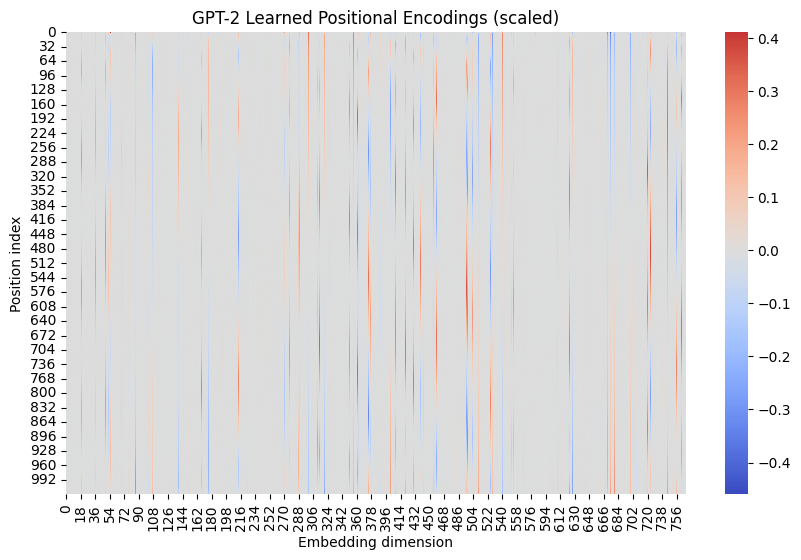

In [13]:
plt.figure(figsize=(10, 6))
#sns.heatmap(positional_encodings, cmap="coolwarm", center = 0)
sns.heatmap(normed_pe, cmap="coolwarm", center = 0)
plt.title("GPT-2 Learned Positional Encodings (scaled)")
plt.xlabel("Embedding dimension")
plt.ylabel("Position index")
plt.show()

### Plot what the heatmap would look like in the case of sinusoidal positional encoding

**ABOUT THE CHOICE OF THE SCALING FACTOR:**
In sinusoidal encoding the value of L(scaling factor) is chosen arbitrarily: it controls how fast the frequencies change across dimensions in the positional encoding. This generates exponentially decreasing frequencies across the embedding dimensions, starting from high frequency in low dimensions (fast oscillation) and getting slower in higher dimensions (slow oscillation).

By **decreasing L**: 
- the frequencies change more quickly across dimensions
- you get higher-frequency patterns (more oscillations) overall
- encodings may distinguish positions more sharply over short distances
- but generalization over longer sequences might degrade (less smoothness)

By **increasing L**: 
- the frequencies vary more slowly.
- you get lower-frequency sinusoids.
- Position encodings change more smoothly — better for capturing long-range patterns but worse for fine-grained local distinctions.

**Summarizing**: 

Changing base is like tuning the "zoom" level of your positional lens:
- _Lower base_ → more detail (zoomed in),
- _Higher base_ → broader view (zoomed out).

In [8]:
# In our usual notation: 
#   max_len = N
#   d_model = D
#   You can check what happens varying L (here is 1000.0) --> just a rescaling

L = 1024

def sinusoidal_positional_encoding(max_len, d_model):
    pe = np.zeros((max_len, d_model)) # Initialize the PE matrix with all zeros
    position = np.arange(0, max_len)[:, np.newaxis] # Column vector of positions
    div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(L) / d_model)) # define the frequencies
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe

sinusoidal_encodings = sinusoidal_positional_encoding(L, 768)
normed_se = sinusoidal_encodings / np.linalg.norm(sinusoidal_encodings, axis=1, keepdims=True)


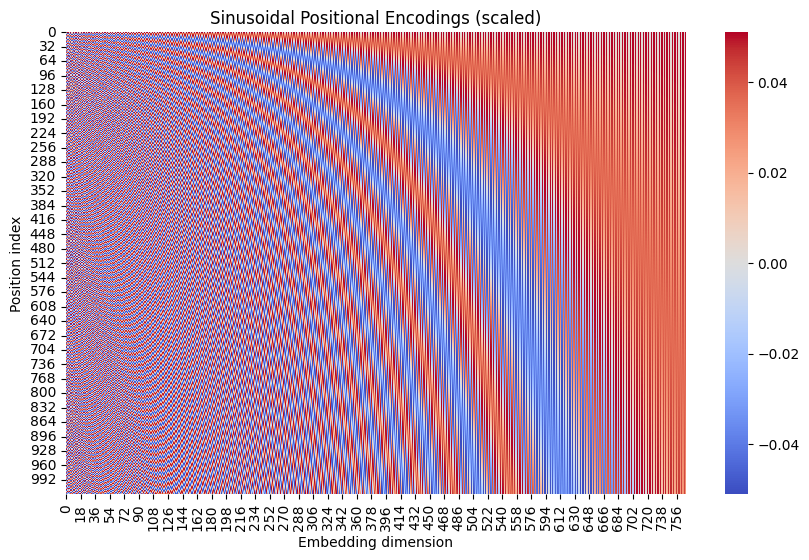

In [14]:
plt.figure(figsize=(10, 6))
#sns.heatmap(sinusoidal_encodings, cmap="coolwarm", center = 0)
sns.heatmap(normed_se, cmap="coolwarm", center = 0)
plt.title("Sinusoidal Positional Encodings (scaled)")
plt.xlabel("Embedding dimension")
plt.ylabel("Position index")
plt.show()


### Radius of the positional trajectory
Now we are trying to answer the following instead: 
**_"How well-separated are different positions in the positional encoding space, so that different tokens don't get mapped too close together?"_**

In other words we're asking about the "radius" of the positional trajectory - how far the points travel and how distinct they are. You want to **avoid aliasing**: two different positions having very similar positional necodings could confuse the model!

**NOTICE:**
We're looking at how the radius goes out from the pure token (let's say located at origin) without positional encoding, depending on the position. It is important to notice here that this DOES NOT DEPEND ON THE TOKEN because the positional "weights" are fixed. 

Imagine hence that in the space it would be like having each token surrounded by a sphere (of possible points where the token is mapped to after positional encoding) of radius that depends on its position. 

Knowing whether tokens are distant enough tho depends strongly on how tokens are embedded (not strictly on the radius of the positional encoding sphere) - you'd have to check that given specific tokens, their spheres once applied PE do not overlap... but this requires further analysis.

Let's start by **computing what is the radius of these spheres** depending on the position is basically **computing the L2 norm of the vector Pn $\forall n$.**

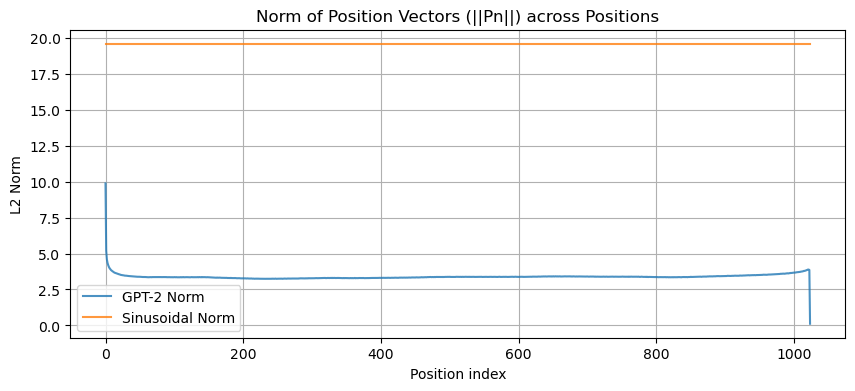

In [7]:
gpt2_norms = np.linalg.norm(positional_encodings, axis=1)
sine_norms = np.linalg.norm(sinusoidal_encodings, axis=1)

plt.figure(figsize=(10, 4))
plt.plot(gpt2_norms, label="GPT-2 Norm", alpha=0.8)
plt.plot(sine_norms, label="Sinusoidal Norm", alpha=0.8)
plt.title("Norm of Position Vectors (||Pn||) across Positions")
plt.xlabel("Position index")
plt.ylabel("L2 Norm")
#plt.xlim(1020,1025)
#plt.ylim(2.5,5)
#plt.ylim(0,1)
plt.legend()
plt.grid(True)
plt.show()


**NOTICE:**

**The sinusoidal encoding** is expected to have a norm of $\sqrt(D/2)$ for each vector. 
Indeed when you're computing the norm of it you're summing pairwise $cos^2 + sin^2$ and then taking square root. 

In other words, by construction each $(\sin,\cos)$ pair at index $i$ satisfies

  $$
    \sin^2(a_i) + \cos^2(a_i) = 1,
  $$

  so for $d$-dimensional (even $d$) encodings,

  $$
    \|P_n\| = \sqrt{\,\tfrac d2\times 1\,}
            = \sqrt{\tfrac d2}.
  $$

  For $d=768$, that’s $\sqrt{384}\approx19.6$.

**Learned GPT-2** instead reaches also a constant value, different though because of training weights initializations.

NOTICE: In models like GPT-2, the input vector for a given token is:

$$
\text{input}_n = \text{token\_embedding}(w_n) + \text{positional\_embedding}(n)
$$

This sum is fed to the transformer. That means the **magnitudes** (norms) of both vectors **determine how much they influence the input**.

 **The model learns how much positional information to inject**.
 Sinusoidal norms are high because they're untrained and fixed.
 GPT-2's norms are lower because the model learns a value that complements the scale of token embeddings without overpowering them.


In [8]:
from transformers import GPT2Tokenizer, GPT2Model
import torch
import numpy as np

# Load model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2Model.from_pretrained(model_name)

# Extract the token embedding matrix
# Shape: (vocab_size, embedding_dim)
embedding_matrix = model.get_input_embeddings().weight.detach().cpu().numpy()

# Compute L2 norms of each token vector
token_norms = np.linalg.norm(embedding_matrix, axis=1)

# Statistics
mean_norm = np.mean(token_norms)
std_norm = np.std(token_norms)
max_norm = np.max(token_norms)
min_norm = np.min(token_norms)

print(f"Average token embedding norm: {mean_norm:.4f}")
print(f"Standard deviation: {std_norm:.4f}")
print(f"Max norm: {max_norm:.4f}")
print(f"Min norm: {min_norm:.4f}")


Average token embedding norm: 3.9585
Standard deviation: 0.4337
Max norm: 6.3155
Min norm: 2.4537


**NOTICE:**
GPT-2 learns its positional embeddings during training to be on the same scale as token embeddings indeed!! 
We saw that learned PE norms are $\sim$ 3.9, just like the tokens!! This ensures a balanced contribution from token identity and position. 

**About the fact that the norm is constant:**

If some *positional vectors* had a much larger *magnitude* than others, the model would assign more *attention weight* to tokens at those positions.
This would unintentionally bias the model toward particular *positions* (e.g., early tokens, middle tokens, etc.).

It could result in worse *generalization* and *position-dependent behavior*, especially in long sequences.
With equal norms, each position contributes equally in magnitude to the input — *no position has an unfair representational "advantage"*.

*This lets attention layers focus on relative distances between tokens* — which is essential for tasks like *syntax*, *rhythm*, and *structure*, where the *relative position* matters more than the *absolute index*.

In simple terms, *attention* is mathematically done using the *dot product* between vectors.

At each layer of a Transformer, we compute attention as:

```math
\text{Attention}(Q, K, V) = \text{softmax} \left( \frac{QK^\top}{\sqrt{d_k}} \right)V
```

Where:

* *Q*: query matrix (comes from the current token you're processing)
* *K*: key matrix (comes from all tokens in the sequence)
* *V*: value matrix (information from the sequence to pass on)
* *dₖ*: dimension size for scaling

The *dot product* $QK^\top$ controls how strongly each token *attends to* others.

Each input token is embedded into a vector, and *a positional encoding vector is added to that token vector*:

```math
\text{Input to transformer} = \text{TokenEmbedding} + \text{PositionEncoding}
```

So the *final vectors (Q, K, V)* that get used in attention *include positional information*.

If some *positional encodings* have much larger *norms* than others:

* The total input vector becomes *much bigger* for tokens at those positions.
* This means those tokens produce *larger Q or K vectors*, and thus *larger dot products* in the attention computation.
* This results in *higher attention scores*, and the model will *unintentionally focus more on those positions*, just because of their magnitude — *not because they're more important*.

This introduces *positional bias* that *hurts generalization*, because:

* The model may learn to overly rely on *specific positions* (e.g., always focusing on the first token).
* This breaks *translation invariance*, making the model worse at handling *long sequences* or *shifted content*.

With all *positional encodings* having the *same magnitude*, every position:

* Contributes *equally* to the input.
* Lets the model *treat each position fairly*, unless it has learned otherwise.
* Preserves the model’s ability to *attend based on content and relative position*, not arbitrary size differences.

This is *crucial* for attention to work well in *general-purpose* settings like *language modeling*.


##### **VERY IMPORTANT**:

**EQUAL PE NORMS GUARANTEE ONLY THAT P_n ITSELF DOES NOT BIAS ATTENTION BY MAGNITUDE: HOWEVER OF COURSE BECAUSE EACH P_n POINTS IN A DIFFERENT DIRECTION OF COURSE THE NORM OF THE SUM TOKEN+POSITION WILL STILL VARY** unless you use a **rotational scheme** (like RoPE that _only_ changes direction and never adds).

**About RoPE**
RoPE encodes position via rotations in the embedding space, i.e., it *rotates* the token embeddings by a position-dependent angle instead of adding a separate positional vector.
Because _rotations preserve vector norms_ (rotating a vector doesn’t change its length), the _norm of the token embedding after applying RoPE stays exactly the same_ for all positions.

This means _the magnitude of the combined (token + position) vector is preserved_ across all positions, so **no unintended bias due to magnitude differences arises: in this way really the only thing that'd matter is the relative angle between the tokens (hence relative position) and not absolute one. 

Basically you'd prefer not using RoPE only if you cared about absolute position (you want to treat some positions as "special ones": for example give the first/last word to have larger norm - or let it be learnt that way)... which is not usually the case. 

Other reasons why we usually _don't_ lean on magnitude to encode position are: 

1. **Magnitude biases are crude**
In Transformers, attention is based on dot products between token vectors (which include both token and positional information). The dot product depends both on angle (direction) and magnitude.

If some positional encodings have much larger norms, they cause their associated tokens to produce larger dot products, regardless of the actual token content. This means:

* The model pays more attention to certain positions, just because the positional vector is bigger.
* This overrides the actual identity or meaning of the token — e.g., “the 3rd word is more important just because it’s in position 3.”

You lose control and nuance:
Let’s say you want the model to focus on the _first token only if_ it’s a question word like *“what”*. If the positional encoding of position 0 has a big magnitude, then _all first-position tokens_ get more attention, whether they’re *“what”* or *“the”* — that's a _blunt, content-agnostic bias_.


2. **Harder to disentangle signals**  
The model is trying to learn two things at once:

* The _content_ of the token (what word it is)
* The _position_ of the token (where it appears in the sequence)

If your positional encodings vary in _both_ magnitude and direction, the model has to disentangle:

* Was a token important because of its _position_ (and if so, was that due to *how large* the position vector was or *what direction* it pointed in)?
* Or because of its _content_?

--> This increases the **learning burden**:

* The model has to learn how to ignore magnitude sometimes (which is hard during optimization).
* It may pick up spurious correlations (e.g., thinking that tokens at the start of a sentence are always more important just because the norm is larger there).


##### **Now let's dive a little deeper on that starting and ending drops in norm**

In [9]:
print("First row (pos 0):", positional_encodings[0, :8])
print("Last  row (pos N-1):", positional_encodings[-1, :8])
print("Norm[0] =", gpt2_norms[0])
print("Norm[-1]=", gpt2_norms[-1])

First row (pos 0): [-0.01882072 -0.1974186   0.00402672  0.01134686  0.06382412 -0.10501328
  0.03693705 -0.16802956]
Last  row (pos N-1): [ 0.0002661   0.00302724 -0.00170865  0.00300505 -0.00131661 -0.00506779
 -0.00480043  0.00176254]
Norm[0] = 9.875602
Norm[-1]= 0.1179292


**Why this?**

The last positional vector is nearly zero because GPT-2 doesn't use it during training. It is effectively unused, so it never got updated - it stayed close to its random-initialization or zero-initialization value. 
Indeed, when training, models are typically fed sequences that are shorter than the max length. GPT-2's training data (e.g, WebText) rarely hits 1024 tokens - most sequences are shorter (512 - 1000). 
Since the embedding matrix is initialized randomly and trained via gradient descent, unused rows remain close to their initial small values. In contrast, frequently-used positions (like pos=0) get trained to have norms compatible with token embeddings (e.g., ~9.8), ensuring balanced attention contributions.

**Why exactly the last one is so different and there is no smooth passage from let's say 1020-1023 index?**
This is due to the fact that if the input sequence is N tokens long, the model only uses the first N-1 positions for training (due to it being used as a target, not input)!! 
In practice: 
- position 0 is used in every sequence --> reach soon convergence (min of gradient descent, if you keep using these positions and updating them, as you do of course also for longer sequences, their norms at some point - when min reached - don't visibly change anymore); 
- positions 1-1022 are used in most sequeces --> still enough to reach convergence; 
- position 1023 is used only in sequences of exactly 1024 tokens, which is rare --> apparently not enough to get updated much.



*(From Miriam) non mi convince questa cosa. Forse...  il 1023 è a zero perchè il modello è pensato per gestire un buffer di massimo 1024 tokens, e durante il training deve predirre il next token. Il next token deve essere aggiunto al buffer, quindi al massimo puoi dare un buffer di 1023 tokens - indici 0-1022.  L'indice 1023 verrà preso dal predicted token, quindi non viene mai usato nel training. Forse. Potrebbe anche essere una cavolata totale.*

### Cosine similarity evolution

**Sinusoidal encoding case:**

We expect sinusoidal positional encodings to provide a *translation-invariant* notion of relative distance: shifting every position by one should look the same in embedding space, so the cosine between $P_n$ and $P_{n+1}$ must be the *same* for all $n$.  Seeing a flat line confirms our implementation is correct.

* Let $d$ be the embedding dimension (assumed even).
* We interleave sine and cosine coordinates in pairs indexed by $i = 0,1, \dots , \frac{d}{2}-1$.

For position $n$, define for each $i$:

$$
a_i \;=\;\frac{n}{10000^{2i/d}},
\qquad
P_n[2i]   = \sin(a_i),
\qquad
P_n[2i+1] = \cos(a_i).
$$

1. Compute the phase increment

   $$
     \Delta_i
     = \frac{n+1}{10000^{2i/d}} \;-\;\frac{n}{10000^{2i/d}}
     = \frac{1}{10000^{2i/d}}.
   $$
2. One sine–cosine pair contributes

   $$
     \sin(a_i)\,\sin(a_i+\Delta_i)
     \;+\;
     \cos(a_i)\,\cos(a_i+\Delta_i).
   $$
3. Apply the trigonometric identity

   $$
     \sin x\,\sin(x+\delta)
     +\cos x\,\cos(x+\delta)
     = \cos\bigl((x+\delta)-x\bigr)
     = \cos(\delta).
   $$
4. Summing over all $d/2$ pairs gives

   $$
     P_n \!\cdot\! P_{n+1}
     = \sum_{i=0}^{d/2-1}\cos(\Delta_i),
   $$

   which is **independent of** $n$.

Since every $P_n$ has the same norm $||P_n||$, the cosine similarity is

$$
\cos(P_n,P_{n+1})
= \frac{P_n\cdot P_{n+1}}{\|P_n\|\;\|P_{n+1}\|}
= \frac{1}{\|P_n\|^2}\sum_{i}\cos(\Delta_i),
$$

and if $|P_n|^2=d$ (or any constant), this is a fixed constant for *all* $n$.

* A **flat** $cos(P_n,P_{n+1})$ means our encoding treats *any* adjacent positions identically (sinusoidal encoding causes a rotation of the same angle from a position to the adjacent one)

* This translation invariance is exactly what lets attention layers reason in terms of *relative* distance, without “drift” as $n$ grows. Indeed it is the _difference_ between positions that matters more than the absolute position. We want the similarity between $P_n$ and $P_{n+k}$ hence to depend only on $k$, not on $n$. 

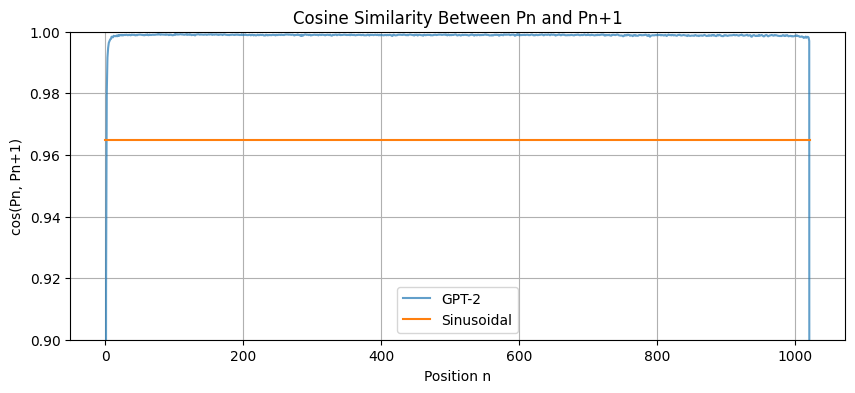

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity between each Pn and Pn+1
cos_sim = [
    cosine_similarity([positional_encodings[i]], [positional_encodings[i+1]])[0, 0] # [0,0] estracts the scalar similarity value from the resulting 1x1 matrix
    for i in range(len(positional_encodings) - 1)
]

cos_sim_sine = [
    cosine_similarity([sinusoidal_encodings[i]], [sinusoidal_encodings[i+1]])[0, 0]
    for i in range(len(sinusoidal_encodings) - 1)
]

plt.figure(figsize=(10, 4))
plt.plot(cos_sim, label="GPT-2", alpha=0.7)
plt.plot(cos_sim_sine, label="Sinusoidal")
#plt.xlim(0,25)
plt.ylim(0.9, 1)
plt.title("Cosine Similarity Between Pn and Pn+1")
plt.xlabel("Position n")
plt.ylabel("cos(Pn, Pn+1)")
plt.legend()
plt.grid(True)
plt.show()


**GPT-2 encoding:**
- **Cosine similarity always close (BUT NOT EQUAL!) to one**: this means that adjacent vectors are ALMOST parallel: putting all together, adjacent positions lie roughly aong the same direction in the embedding space, just slightly differing in magnitude (actually only for boundary positions) or with very subtle component change. 

- Notice that **learned embeddings are free to optimize** (no strict constraints like sinusoidal embeddings): the model may have found that small directional changes or magnitude shifts in positional embeddings suffice to encode position information for the attention mechanism. 

OR ! Another possibility is that this behavior reflects embedding redundancy or embedding space collaps in certain position ranges, possibly due to undertraining or limited sequence lengths used during training for these positions.  

**MORE IN DETAIL:**
- **Why does cosine similarity fluctuate strongly at boundaries?**

At the start and end of the positional embedding range, cosine similarity between adjacent positions often drops significantly, indicating larger directional changes there.

This usually happens because:

1. Boundary positions (like position 0 or the max position 1023) are special. For example, position 0 corresponds to the start of a sequence (e.g., beginning of sentence or prompt).

2. The model might want to mark boundaries distinctly, so it learns more dramatic changes in embeddings at these positions.
The last positions might be less frequently encountered or represent padding/truncation, causing different learned patterns.

- **Why do intermediate indices fluctuate? Is it only noise?**
The fluctuations at intermediate positions are often a combination of:

a) Real, subtle differences learned by the model to encode positional info.
Some amount of statistical noise from finite training, random initialization, and optimization dynamics.

b) The positional embeddings are learned parameters, so they don’t necessarily form perfectly smooth progressions like sinusoids. Fluctuations likely reflect the model’s attempt to balance position encoding with token semantics and regularization effects (REMEMBER that positional embeddings are learned jointly with token embeddings and the whole model: the model tries to balance encoding position-specific signals, not interfering too much with token semantics and respecting regularization or other implicit constraints).

- **Does "moving less" in cosine similarity imply optimization or undertraining?**

Since the positions of those values are frequently reached (they're not found only rarely or at boundaries) this is a sign of optimization (model has found a stable, optimized embedding configuration) rather than lack of training that may cause embeddings to be "stuck" or less refined (if those positions were rarely used (e.g., near the max sequence length that appears seldom), embeddings might show high similarity simply because they didn’t get enough gradient updates). 

### SUMMARY SO FAR:

1. **Norms of Positional Encodings (PEs):**

   * GPT-2 learns PEs with norms close to token embeddings (\~3.9), ensuring balanced input.
   * The last position’s embedding (e.g. index 1023) often has near-zero norm due to undertraining (rarely used in next-token prediction).
   * The norms across most positions are roughly constant — a sign of convergence, not necessarily equal usage.

2. **Why Equal Norms Matter:**

   * If PE magnitudes vary, they bias attention weights unfairly toward certain positions.
   * Equal norms help prevent such positional bias, ensuring that attention focuses on **content** and **relative position**, not raw magnitude.
   * Positional differences should ideally be encoded through **direction** (angular shift), not norm.

3. **Magnitude vs Direction:**

   * Using **only direction** for encoding positions (e.g. RoPE) allows the model to better disentangle “what” from “where."

4. **Fluctuations in Cosine Similarity:**

   * Sinusoidal encodings have a constant cosine similarity between adjacent positions — perfect for encoding relative distances.
   * GPT-2’s learned PEs show fluctuating cosine similarity across adjacent positions.
   
     * Some of this may reflect meaningful structure (e.g., modeling boundaries or tasks).
     * Some may result from the optimization process balancing PE smoothness, data frequency, and model regularization.

5. **Cosine Similarity Close to 1:**

   * Could mean stable optimized embeddings (small shifts suffice).
   * Could also indicate undertraining — but since our observed region is used frequently, it's likely optimization.


### Overall cosine-similarity heatmaps

(They don't add any information, but since they're here let's try to interpret them)

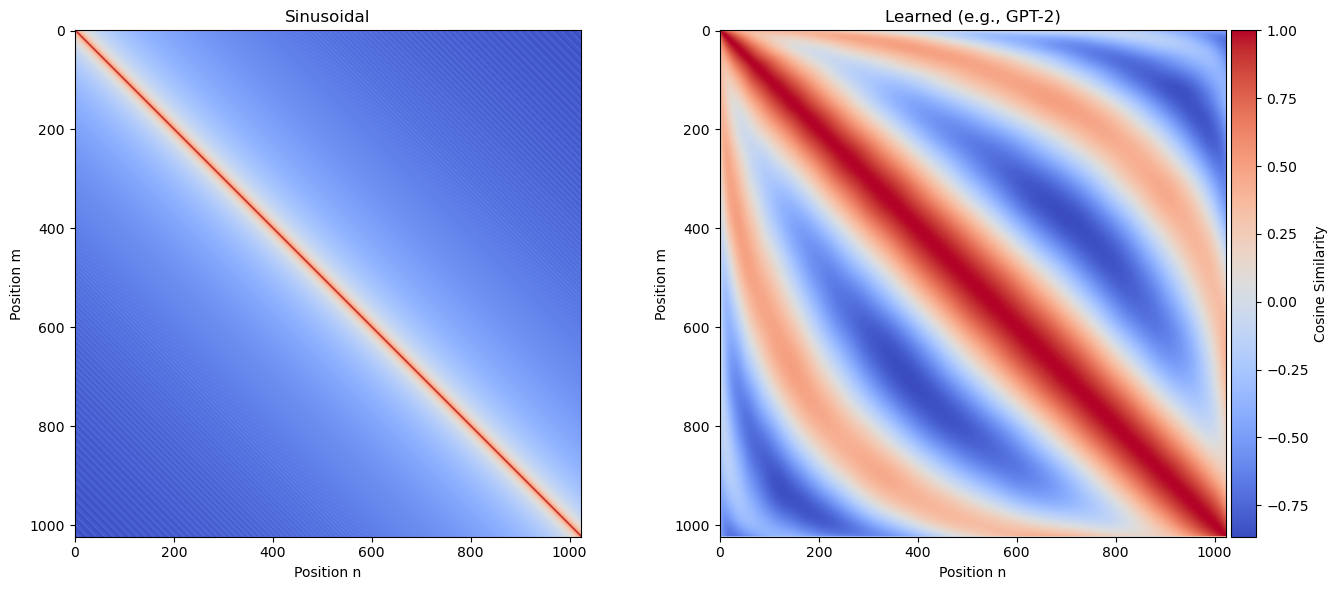

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Compute similarity matrices
sim_sin = cosine_similarity(sinusoidal_encodings)
sim_learned = cosine_similarity(positional_encodings)

# Plot sinusoidal
im0 = axs[0].imshow(sim_sin, cmap='coolwarm')
axs[0].set_title("Sinusoidal")
axs[0].set_xlabel("Position n")
axs[0].set_ylabel("Position m")

# Plot learned
im1 = axs[1].imshow(sim_learned, cmap='coolwarm')
axs[1].set_title("Learned (e.g., GPT-2)")
axs[1].set_xlabel("Position n")
axs[1].set_ylabel("Position m")

# Use make_axes_locatable to avoid overlap
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax, label="Cosine Similarity")

plt.tight_layout()
plt.show()

**Sinusoidal Heat-Map**
We see:
- A bright main diagonal where cosine similarity is 1.
- As we move off the diagonal, similarity decays smoothly.
- If we look at column $n = 0$ we see small ripples rather than a perfectly monotonic drop.

The encoding is indeed defined by

$$
P_n[2i] = \sin\!\bigl(\tfrac{n}{10000^{2i/d}}\bigr),
\qquad
P_n[2i+1] = \cos\!\bigl(\tfrac{n}{10000^{2i/d}}\bigr).
$$

The similarity $cos(P_0,P_m)$ is

$$
\frac{1}{d}\sum_{i=0}^{d/2-1}\cos\!\Bigl(\tfrac{m}{10000^{2i/d}}\Bigr).
$$

This is a sum of many cosines at different, incommensurate frequencies. The overall envelope decays with $m$, but you see small oscillations (beats) whenever components align.

--> IN MORE DETAIL:

The cosine similarity between P₀ and Pₘ in sinusoidal positional encoding is given by:

$$
\cos(P_0, P_m) = \frac{1}{d} \sum_{i=0}^{d/2-1} \cos\left(\frac{m}{10000^{2i/d}}\right)
$$

The overall similarity decreases with increasing m due to the following reasons:

1. Incommensurate frequencies  
   Each cosine uses a slightly different frequency. When m is small, the terms are nearly aligned. As m increases, their phases diverge.

2. Phase cancellation  
   With greater m, cosine terms go more out of phase and partially cancel each other out, reducing the total sum and thus the similarity.

3. Beat interference  
   Occasionally, cosine terms temporarily align, producing oscillations. These are visible as small fluctuations in similarity.

4. Fixed norms  
   The decay is in cosine similarity (angle between vectors), not in vector magnitudes. All positional encodings have the same norm.

While the cosine similarity fluctuates due to interference between terms, its average value decreases with m because alignment becomes rarer as phase differences increase.

**GPT-2 Learned PE Heat-Map**

What we see:
- Strong, colorful bands that look periodic along anti-diagonals.
- In the main diagonal region similarity is near 1, then clear red/blue stripes appear at regular spacings.

Learned embeddings indeed concentrate variance in a few principal directions. Those dominant directions act like one or two strong cosines, so

$$
\cos(P_n,P_{n+k}) \approx \cos(\omega k)
$$

for some $\omega$, producing visible stripes (sum of few different frequencies = quasi-periodic behavior). 


### PCA 
**Each point in the 2D plot corresponds to one position (0 to 1023), represented in the reduced PCA space**.

- Both learned (GPT-2) and sinusoidal matrices are size 1024 × 768: each row is a position vector, each column is an embedding dimension.

- PCA helps reduce high-dimensional vectors to 2D or 3D, so you can visualize trajectories or structures in position space.

- It allows us to compare how the position vectors evolve across n and see whether the learned embeddings form curved, linear, or more complex manifolds.

**How many dimensions retain 90% of variance?**

In [15]:
positional_encodings.shape

(1024, 768)

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# PCA for GPT-2 learned positional encodings
pca_gpt2 = PCA() # create PCA objects (nsamples, nfeatures) = (1024, 768)
pca_gpt2.fit(positional_encodings) # compute the PC of normalized GPT-2 positional encodings 
cumsum_gpt2 = np.cumsum(pca_gpt2.explained_variance_ratio_) # cumulative sum of how much vairnace each component explains
n_components_gpt2 = np.searchsorted(cumsum_gpt2, 0.90) + 1 # find the index of the first component where cumulative variance reaches of exceeds 0.90 (plus one because of Python's zero-base)

# PCA for sinusoidal positional encodings
pca_sine = PCA()
pca_sine.fit(sinusoidal_encodings)
cumsum_sine = np.cumsum(pca_sine.explained_variance_ratio_)
n_components_sine = np.searchsorted(cumsum_sine, 0.90) + 1

print(f"GPT-2 Learned Positional Encoding: {n_components_gpt2} components retain 90% variance")
print(f"Sinusoidal Positional Encoding: {n_components_sine} components retain 90% variance")


GPT-2 Learned Positional Encoding: 3 components retain 90% variance
Sinusoidal Positional Encoding: 153 components retain 90% variance


### Evolution of positional vectors as n increases (from 1 to N) along different dimensions

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_5301/595394886.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


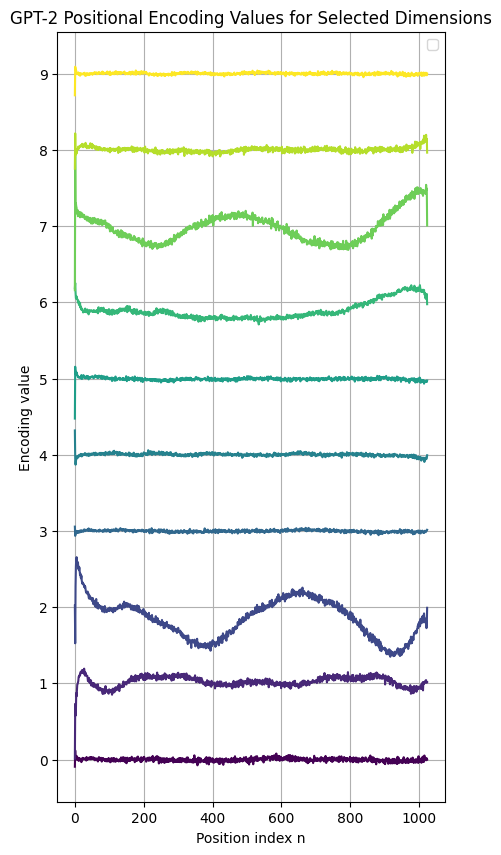

In [44]:
N = 10

dims_to_plot = np.arange(0, N)
cmap = plt.get_cmap('viridis', N)  # Discretized colormap
offset = 0.2
fig, ax = plt.subplots(figsize = (5, 10))
for i, dim in enumerate(dims_to_plot):
# for dim in np.arange(1, 768,10):
    p = positional_encodings[:, dim]
    p_scaled = 2* p / np.max(p)
    ax.plot(p + i * offset, color = cmap(i))
plt.title("GPT-2 Positional Encoding Values for Selected Dimensions")
plt.xlabel("Position index n")
plt.ylabel("Encoding value")
plt.legend()


yticks_positions = dims_to_plot * offset
ax.set_yticks(yticks_positions)
ax.set_yticklabels(dims_to_plot)

plt.grid(True)
plt.show()

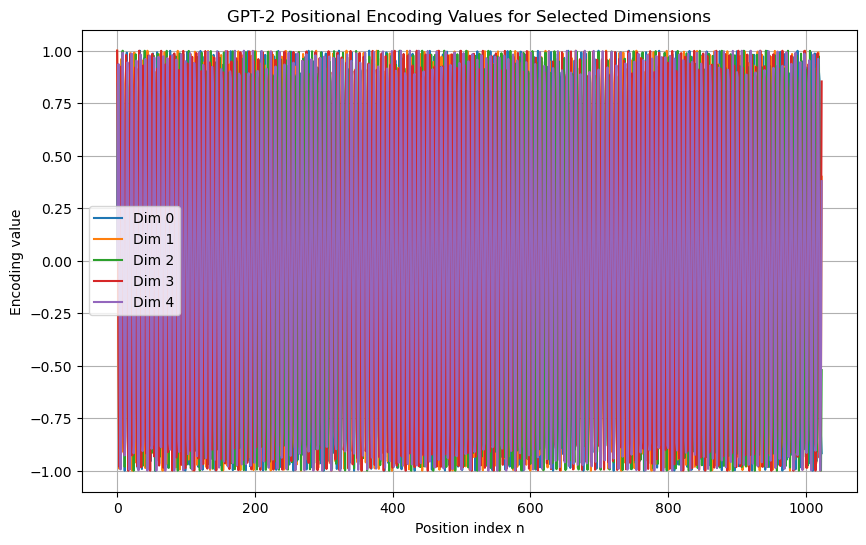

In [16]:
dims_to_plot = [0, 1, 2, 3, 4]

plt.figure(figsize=(10, 6))
for dim in dims_to_plot:
#for dim in np.arange(1, 768,10):
    plt.plot(sinusoidal_encodings[:, dim], label=f"Dim {dim}")
plt.title("GPT-2 Positional Encoding Values for Selected Dimensions")
plt.xlabel("Position index n")
plt.ylabel("Encoding value")
plt.legend()
plt.grid(True)
plt.show()


# SUMMARY:

GPT-2’s **learned positional embeddings** have several advantages over fixed sinusoidal ones:

* **Lower dimensionality for main variance:** fewer principal components explain most of the variance, so the encoding is more compact and efficient.

* **Less "drift" or drastic changes:** embeddings move subtly across positions, which helps maintain smoothness while still distinguishing positions.

* **Norms closer to token embeddings:** balancing the positional and token information prevents positional dominance, helping the model weigh content and position fairly.

* **Flexibility from training:** learned embeddings adapt to the data distribution and model needs, likely capturing richer and more task-relevant positional patterns than hand-crafted sinusoids.

So learned embeddings in GPT-2 are indeed “better” in many practical ways — more balanced, adaptive, and effective for downstream tasks.


### Back to first question: 
### Do vector encodings overlap after adding positional encoding?

##### Pairwise distances between encodings

Compute the **Euclidean distance** between each pair of positional encodings \||$\mathbf{P}_n - \mathbf{P}_m||$. If this distance is **greater than the sum of the radii** (i.e., norms) for positions $n$ and $m$, then the spheres **do not overlap**.

Formally, if:

$$
\|\mathbf{P}_n - \mathbf{P}_m\| > \|\mathbf{P}_n\| + \|\mathbf{P}_m\|
$$

then the spheres are guaranteed to be non-overlapping.

However, since we often use the same norm (or similar magnitudes) across positions, checking this strict condition may be **too strong**. In practice, we can treat the **distance between encodings** as a useful **proxy for how well-separated** the positions are in the embedding space.


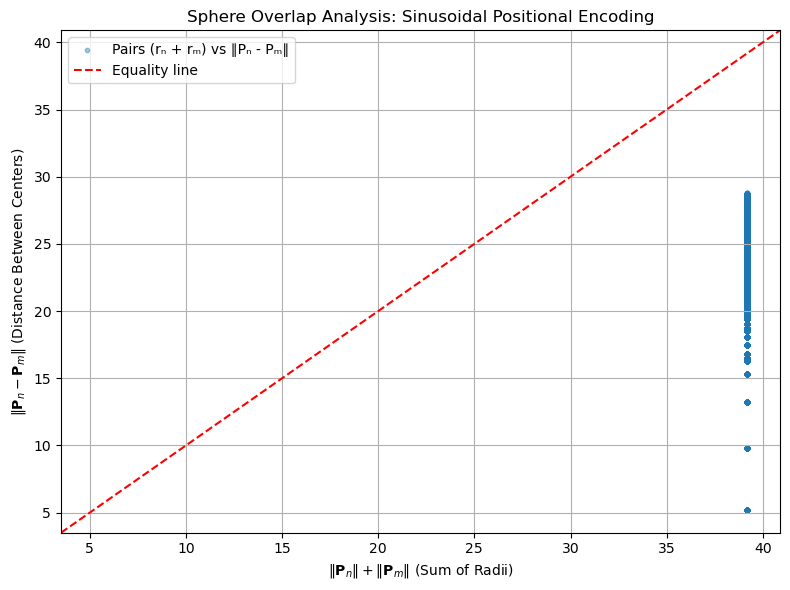

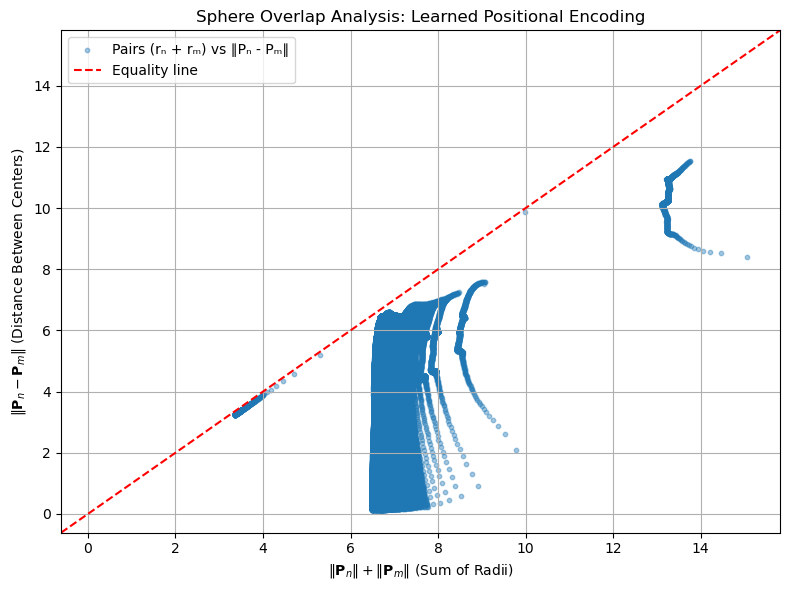

In [21]:
from scipy.spatial.distance import pdist, squareform

def analyze_overlap(encodings, title):
    norms = np.linalg.norm(encodings, axis=1)  # Radii (norms)
    distances = squareform(pdist(encodings, metric='euclidean'))  # Distances between centers
    radius_sums = norms[:, None] + norms[None, :]  # Sum of radii

    # Extract upper triangle (excluding diagonal)
    i, j = np.triu_indices_from(distances, k=1)
    dist_flat = distances[i, j]
    radius_sum_flat = radius_sums[i, j]

    # Get axis limits
    min_val = min(dist_flat.min(), radius_sum_flat.min())
    max_val = max(dist_flat.max(), radius_sum_flat.max())
    buffer = 0.05 * (max_val - min_val)  # small buffer for aesthetics
    axis_min = min_val - buffer
    axis_max = max_val + buffer

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(radius_sum_flat, dist_flat, alpha=0.4, s=10, label='Pairs (rₙ + rₘ) vs ∥Pₙ - Pₘ∥')
    plt.plot([axis_min, axis_max], [axis_min, axis_max], 'r--', label='Equality line')
    plt.xlabel(r'$\|\mathbf{P}_n\| + \|\mathbf{P}_m\|$ (Sum of Radii)')
    plt.ylabel(r'$\|\mathbf{P}_n - \mathbf{P}_m\|$ (Distance Between Centers)')
    plt.title(f'Sphere Overlap Analysis: {title}')
    plt.xlim(axis_min, axis_max)
    plt.ylim(axis_min, axis_max)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Analyze both encodings
analyze_overlap(sinusoidal_encodings, "Sinusoidal Positional Encoding")
analyze_overlap(positional_encodings, "Learned Positional Encoding")

With only this condition we cannot be sure that the spheres do not overlap, since the condition $\|\mathbf{P}_n - \mathbf{P}_m\| > \|\mathbf{P}_n\| + \|\mathbf{P}_m\|$ is not satisfied. 


# NO CONCLUSION YET HERE

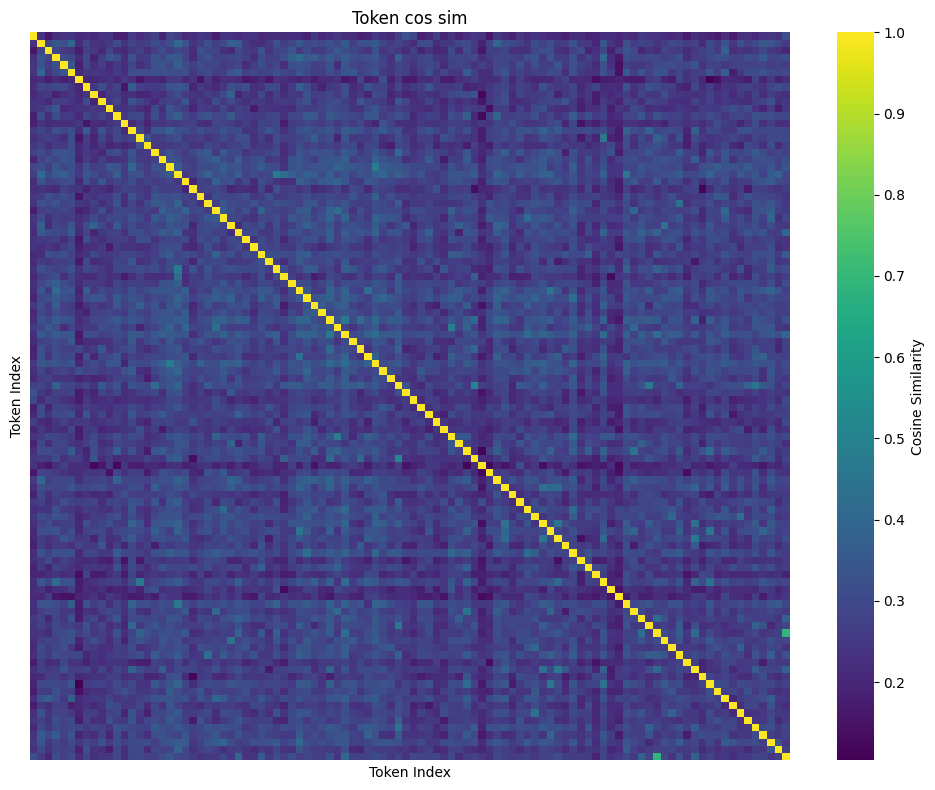

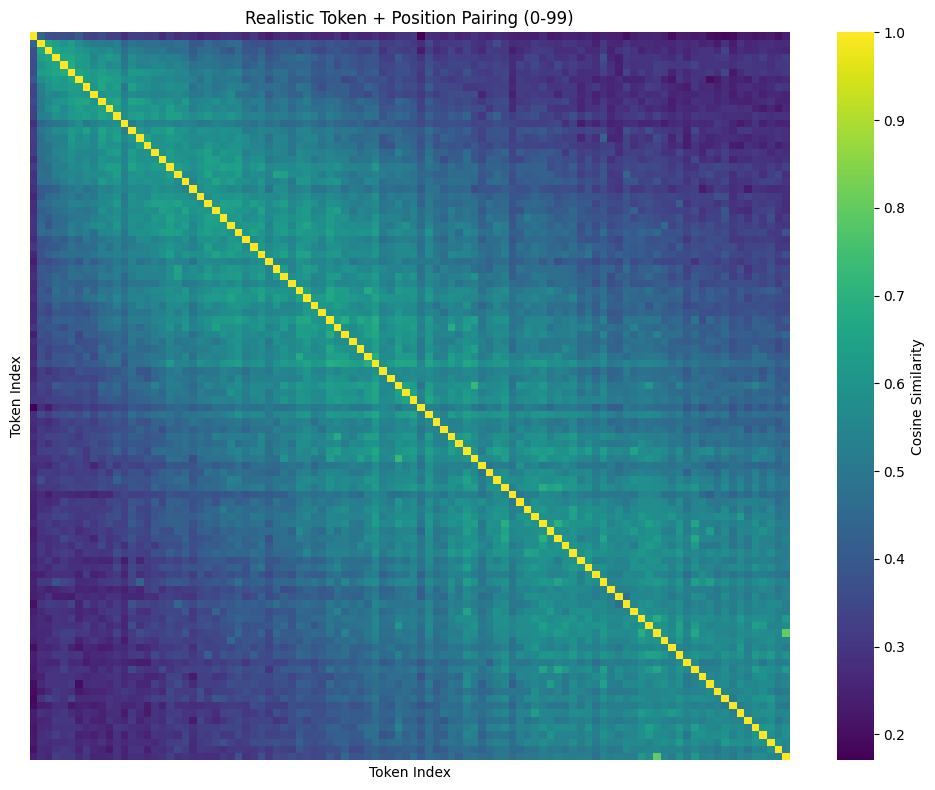

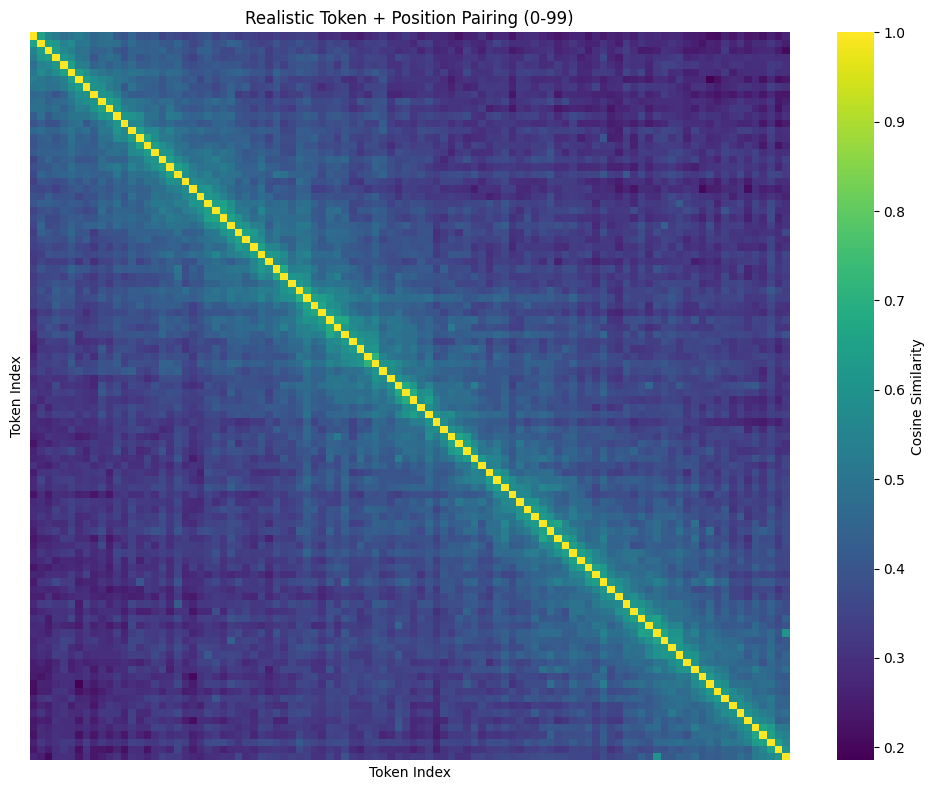

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cosine_similarity(embeddings, title="Cosine Similarity"):
    """
    Plots a heatmap of cosine similarities between the input embeddings.
    
    Parameters:
    - embeddings: np.ndarray of shape (n_samples, d_model)
    - title: Title of the plot
    """
    cos_sim_matrix = cosine_similarity(embeddings)
    
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(cos_sim_matrix, cmap='viridis', xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xlabel("Token Index")
    plt.ylabel("Token Index")
    # Attach the colorbar using the heatmap axis (`ax`)
    cbar = ax.collections[0].colorbar
    cbar.set_label("Cosine Similarity")
    plt.tight_layout()
    plt.show()


# 1. Extract token and positional embeddings
token_embeds = model.wte.weight.detach().cpu().numpy()  # (vocab_size, d_model)
positional_encodings = model.wpe.weight.detach().cpu().numpy()  # (max_len, d_model)

# 2. Simulate a sequence of 100 tokens and assign them to positions 0-99
np.random.seed(42)
num_samples = 100
token_indices = np.random.choice(token_embeds.shape[0], num_samples, replace=False)
pos_indices = np.arange(num_samples)  # positions 0 to 99

# Before adding positional embedding
plot_cosine_similarity(token_embeds[token_indices], "Token cos sim")

# with gpt learned encoding...
combined_embeds = token_embeds[token_indices] + positional_encodings[pos_indices]
plot_cosine_similarity(combined_embeds, "Realistic Token + Position Pairing (0-99)")


# With a scaledc version of sinusoidal encoding...
combined_embeds_sin = token_embeds[token_indices] + (3.95 / 19) * sinusoidal_encodings[pos_indices]
plot_cosine_similarity(combined_embeds_sin, "Realistic Token + Position Pairing (0-99)")

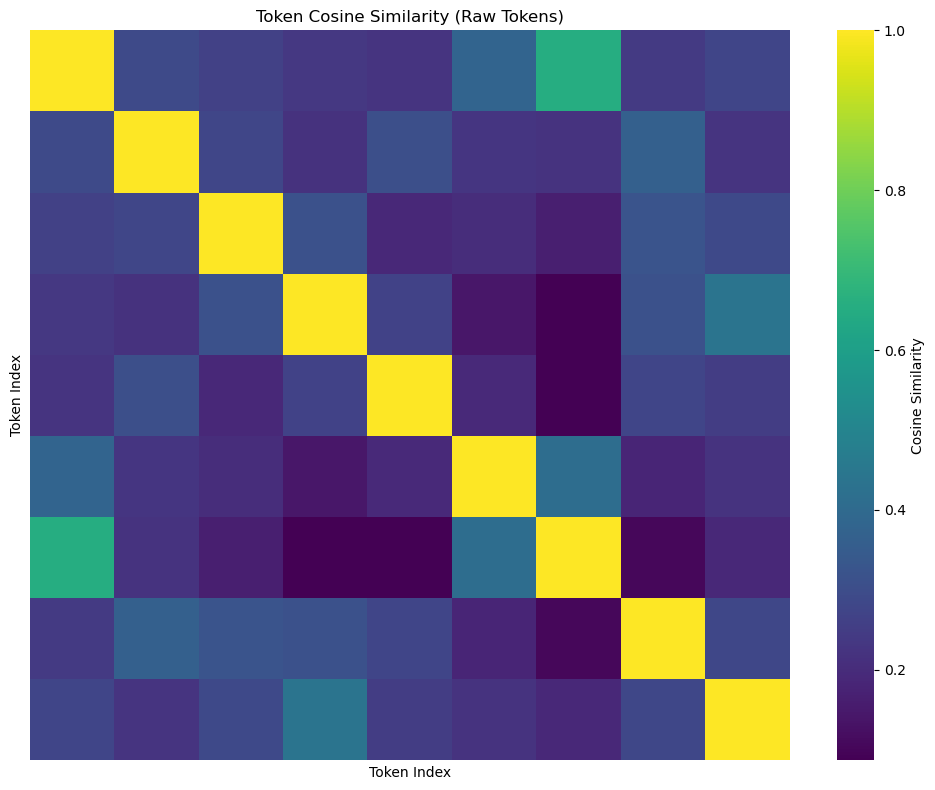

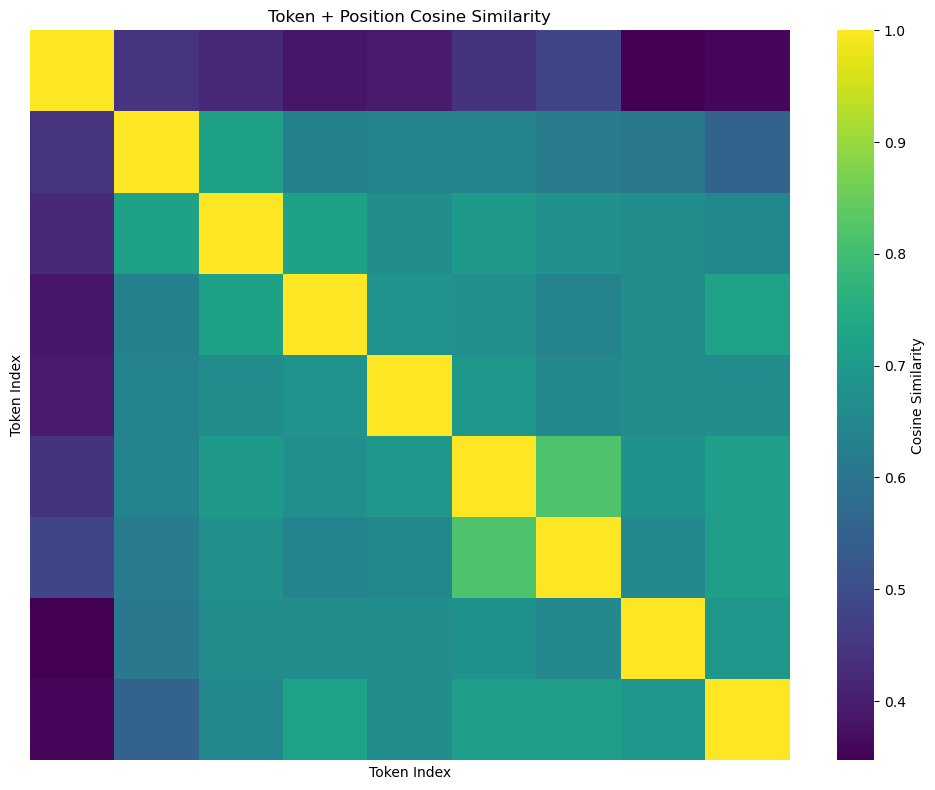

In [29]:
sentence = "The quick brown fox jumps over the lazy dog"
from transformers import GPT2Tokenizer

# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Tokenize the sentence
input_ids = tokenizer.encode(sentence, return_tensors='pt')  # shape: (1, seq_len)
token_indices = input_ids[0].cpu().numpy()  # shape: (seq_len,)

# Get the sequence length
seq_len = token_indices.shape[0]

# Positional indices (just 0 to seq_len-1)
pos_indices = np.arange(seq_len)

# Get token and position embeddings
token_embeds = model.wte.weight.detach().cpu().numpy()  # (vocab_size, d_model)
positional_encodings = model.wpe.weight.detach().cpu().numpy()  # (max_len, d_model)

# Extract embeddings for the sentence
tokens_embed = token_embeds[token_indices]  # (seq_len, d_model)
positions_embed = positional_encodings[pos_indices]  # (seq_len, d_model)

# Combine them
combined_embeds = tokens_embed + positions_embed
plot_cosine_similarity(tokens_embed, "Token Cosine Similarity (Raw Tokens)")
plot_cosine_similarity(combined_embeds, "Token + Position Cosine Similarity")
